In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import random
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
from torchinfo import summary
from tqdm.auto import tqdm
import torch.optim as optim
import pickle

path = "Data"
labelFile = "labels.csv"
BATCH_SIZE = 20
epochs = 1
steps_per_epoch = 2000
imageDimensions = (32,32,3)
test_ratio = 0.2
validation_ratio = 0.2

#import images

cnt = 0
images = []
classno = []
list_data = os.listdir(path)
print(len(list_data))
no_of_classes = len(list_data)

for i in range(no_of_classes):
    pic_list = os.listdir(path+"/"+str(cnt))
    for pic in pic_list:
        pic_path = path+"/"+str(cnt)+"/"+pic
        img = cv2.imread(pic_path)
        images.append(img)
        classno.append(cnt)
    print(cnt)
    cnt += 1

images = np.array(images)
classno = np.array(classno)
print(images.shape)
print(classno.shape)

#split data
X_train, X_test, y_train, y_test = train_test_split(images, classno, test_size=test_ratio)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_ratio)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

43
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
(34796, 32, 32, 3)
(34796,)
(22268, 32, 32, 3)
(6960, 32, 32, 3)
(5568, 32, 32, 3)


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
data = pd.read_csv(labelFile)
print(data.shape)
print(data.head())

(43, 2)
   ClassId                  Name
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)
4        4  Speed limit (70km/h)


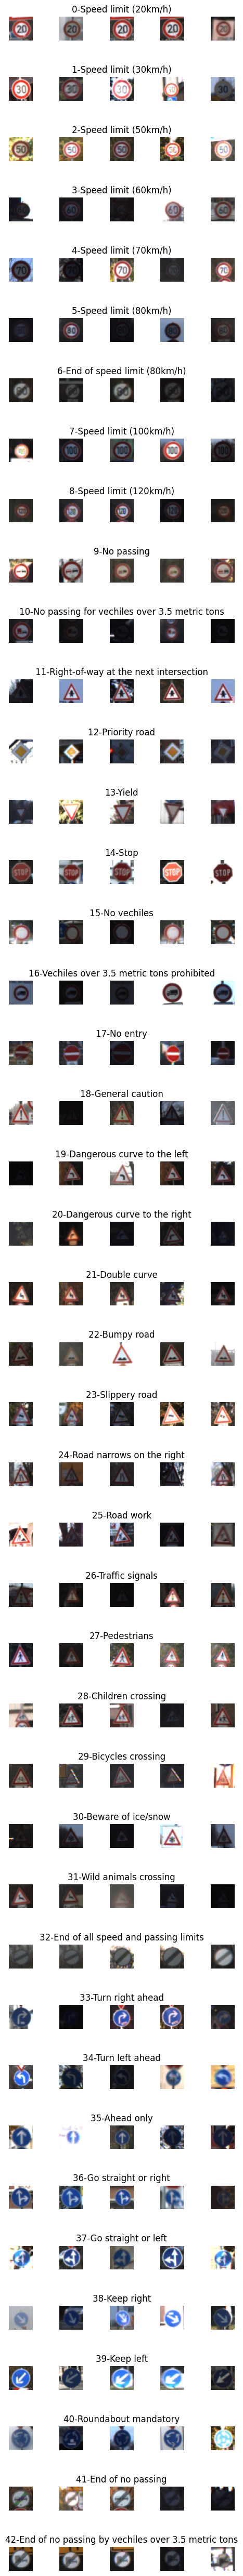

In [5]:
num_of_samples = []
cols = 5
num_classes = no_of_classes

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
for i in range(cols):
    for j,row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[np.random.randint(0,len(x_selected)) - 1,:,:], cmap="gray")
        axs[j][i].axis("off")
        if i==2:
            axs[j][i].set_title(str(j)+ "-" + row["Name"])
            num_of_samples.append(len(x_selected))

[116, 1262, 1274, 820, 1112, 1062, 236, 864, 791, 825, 1160, 760, 1186, 1215, 420, 357, 219, 628, 740, 107, 180, 189, 215, 293, 156, 898, 349, 131, 296, 145, 244, 447, 142, 389, 228, 706, 216, 120, 1141, 172, 191, 129, 137]


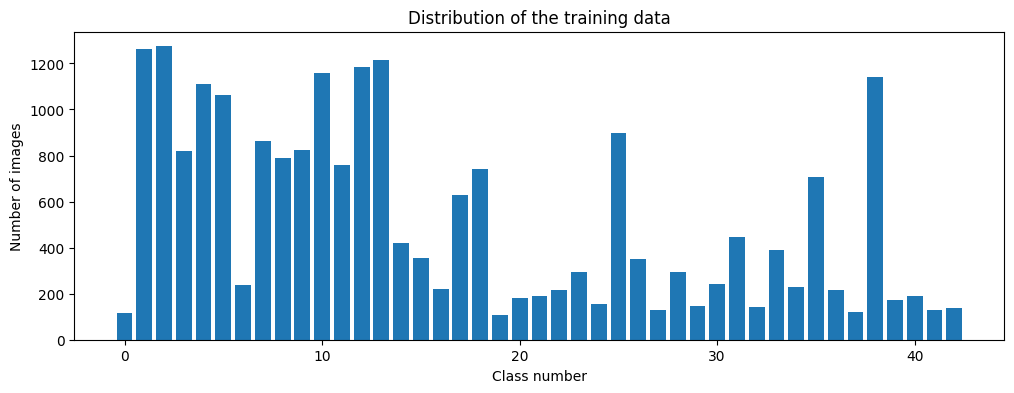

In [6]:
print(num_of_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0,num_classes), num_of_samples)
plt.title("Distribution of the training data")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [8]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img
def equalize(img):
    img = cv2.equalizeHist(img)
    return img
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing,X_test)))


In [9]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

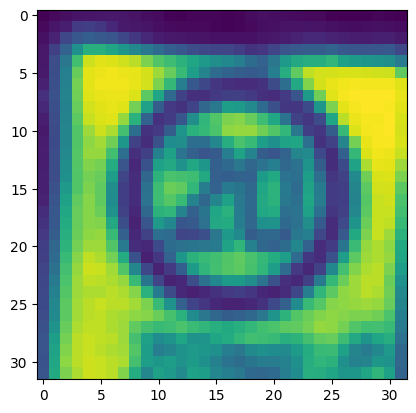

In [10]:
plt.imshow(X_train[0])

In [11]:
data_transforms = transforms.Compose([
    transforms.RandomAffine(
        degrees=10,
        translate=(0.1, 0.1),
        scale=(0.8, 1.2),
        shear=10
    ),
    transforms.ToTensor()
])

In [12]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Args:
            images (numpy.ndarray): Image data (N, H, W, C).
            labels (numpy.ndarray): Corresponding labels (N,).
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert NumPy image (H, W, C) to PIL image for transformation
        image = transforms.ToPILImage()(image)

        if self.transform:
            image = self.transform(image)

        return image, label

In [13]:
X_train_dataset = CustomDataset(X_train, y_train, transform=data_transforms)
X_val_dataset = CustomDataset(X_val, y_val,transform=data_transforms)
X_test_dataset = CustomDataset(X_test, y_test)

X_train_loader = DataLoader(X_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
X_val_loader = DataLoader(X_val_dataset, batch_size=BATCH_SIZE)
X_test_loader = DataLoader(X_test_dataset, batch_size=BATCH_SIZE)

X_train_dataset[3478][0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

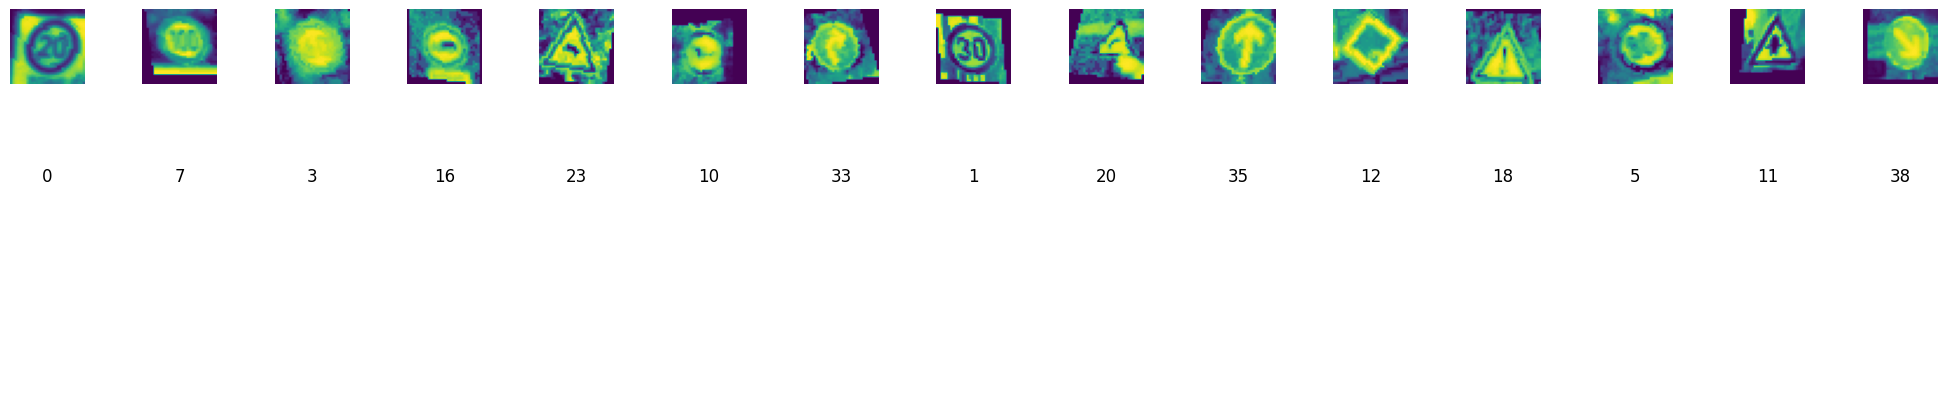

In [14]:
fig,axs=plt.subplots(2,15,figsize=(20,5))
fig.tight_layout()

for i in range(15):
    axs[0][i].imshow(X_train_dataset[i][0].numpy().reshape(32,32,1))
    axs[1][i].set_title(X_train_dataset[i][1])
    axs[0][i].axis('off')
    axs[1][i].axis('off')
plt.show()

In [15]:
class MyModel(nn.Module):
    def __init__(self,input_shape,num_classes):
        super(MyModel, self).__init__()
        no_of_filters = 60
        size_of_filter = (5,5)
        size_of_filter2 = (3,3)
        size_of_pool = (2,2)
        no_of_nodes = 500

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = no_of_filters, kernel_size = size_of_filter)
        self.conv2 = nn.Conv2d(in_channels = no_of_filters, out_channels = no_of_filters, kernel_size = size_of_filter)
        self.pool1 = nn.MaxPool2d(kernel_size = size_of_pool)

        self.conv3 = nn.Conv2d(in_channels = no_of_filters, out_channels = no_of_filters//2, kernel_size = size_of_filter2)
        self.conv4 = nn.Conv2d(in_channels = no_of_filters//2, out_channels = no_of_filters//2, kernel_size = size_of_filter2)
        self.pool2 = nn.MaxPool2d(kernel_size = size_of_pool)

        self.flat = nn.Flatten()

        self.fc1 = nn.Linear(self.get_flatten_shape(input_shape), no_of_nodes)
        self.fc2 = nn.Linear(no_of_nodes, num_classes)

        self.dropout = nn.Dropout(p=0.5)

    def get_flatten_shape(self, input_shape):
        dummy_input = torch.zeros(1, 1, input_shape[2], input_shape[3])
        x = self.pool1(self.conv2(self.conv1(dummy_input)))
        x = self.pool2(self.conv4(self.conv3(x)))
        return x.numel()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout(x)

        x = F.relu(self.fc1(self.flat(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [16]:
input_shape = X_train_dataset[0][0].shape
num_classes = no_of_classes
model = MyModel(input_shape=[1,1,32,32], num_classes=num_classes).to(device)
model

MyModel(
  (conv1): Conv2d(1, 60, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(60, 60, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(60, 30, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=480, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=43, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [24]:
img_batch, label_batch = next(iter(X_train_loader))
print(f"Image batch shape: {img_batch.shape}\n")
print(f"Label batch shape: {label_batch.shape}")
# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model.eval()
with torch.inference_mode():
    pred = model(img_single.to(device))

# 4.convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Image batch shape: torch.Size([20, 1, 32, 32])

Label batch shape: torch.Size([20])
Single image shape: torch.Size([1, 1, 32, 32])

Output logits:
tensor([[-52.4032, -25.1376, -20.0549, -17.8524, -31.8986, -14.8899, -28.7197,
         -12.7329, -25.3887, -38.1205, -38.1968, -20.9980,  14.0905, -31.1300,
         -18.0466, -16.3131, -25.4936, -17.8114, -36.6287, -54.8762, -34.4018,
         -39.2072, -47.4118, -41.3617, -28.5492, -21.2107, -42.1522, -34.4184,
         -32.4395, -27.6665, -23.0184, -43.9725, -14.5156, -20.5723, -22.8795,
         -14.4570, -27.1652, -23.3064, -15.2814, -16.1650,  -6.7639, -18.5499,
         -15.2056]])

Output prediction probabilities:
tensor([[1.3249e-29, 9.1934e-18, 1.4820e-15, 1.3408e-14, 1.0647e-20, 2.5942e-13,
         2.5572e-19, 2.2427e-12, 7.1517e-18, 2.1139e-23, 1.9585e-23, 5.7715e-16,
         1.0000e+00, 2.2962e-20, 1.1042e-14, 6.2500e-14, 6.4396e-18, 1.3970e-14,
         9.3965e-23, 1.1173e-30, 8.7115e-22, 7.1302e-24, 1.9494e-27, 8.2683e-25,


In [19]:
summary(model, input_size = [1,1,32,32])

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [1, 43]                   --
├─Conv2d: 1-1                            [1, 60, 28, 28]           1,560
├─Conv2d: 1-2                            [1, 60, 24, 24]           90,060
├─MaxPool2d: 1-3                         [1, 60, 12, 12]           --
├─Conv2d: 1-4                            [1, 30, 10, 10]           16,230
├─Conv2d: 1-5                            [1, 30, 8, 8]             8,130
├─MaxPool2d: 1-6                         [1, 30, 4, 4]             --
├─Dropout: 1-7                           [1, 30, 4, 4]             --
├─Flatten: 1-8                           [1, 480]                  --
├─Linear: 1-9                            [1, 500]                  240,500
├─Dropout: 1-10                          [1, 500]                  --
├─Linear: 1-11                           [1, 43]                   21,543
Total params: 378,023
Trainable params: 378,023
Non-trainable 

In [20]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [21]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [22]:
# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

c:\Users\yash jain\Desktop\ml project\trafffic sign detector\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = model.parameters(), lr=0.001)

pickle_in=open("model_trained.p","rb")
model=pickle.load(pickle_in)



In [27]:
results = train(model = model, train_dataloader=X_train_loader, test_dataloader=X_val_loader,optimizer = optimizer, loss_fn=loss_fn,epochs=15)

  7%|▋         | 1/15 [00:38<09:03, 38.84s/it]

Epoch: 1 | train_loss: 2.3195 | train_acc: 0.3361 | test_loss: 1.3468 | test_acc: 0.5879


 13%|█▎        | 2/15 [01:20<08:49, 40.74s/it]

Epoch: 2 | train_loss: 1.1379 | train_acc: 0.6443 | test_loss: 0.6006 | test_acc: 0.8151


 20%|██        | 3/15 [02:00<08:00, 40.07s/it]

Epoch: 3 | train_loss: 0.7974 | train_acc: 0.7493 | test_loss: 0.4286 | test_acc: 0.8768


 27%|██▋       | 4/15 [02:39<07:17, 39.74s/it]

Epoch: 4 | train_loss: 0.6603 | train_acc: 0.7927 | test_loss: 0.3887 | test_acc: 0.8833


 33%|███▎      | 5/15 [03:18<06:36, 39.63s/it]

Epoch: 5 | train_loss: 0.5491 | train_acc: 0.8299 | test_loss: 0.3009 | test_acc: 0.9186


 40%|████      | 6/15 [03:59<06:00, 40.01s/it]

Epoch: 6 | train_loss: 0.4987 | train_acc: 0.8476 | test_loss: 0.2894 | test_acc: 0.9206


 47%|████▋     | 7/15 [04:40<05:21, 40.19s/it]

Epoch: 7 | train_loss: 0.4359 | train_acc: 0.8609 | test_loss: 0.2121 | test_acc: 0.9366


 53%|█████▎    | 8/15 [05:21<04:42, 40.42s/it]

Epoch: 8 | train_loss: 0.4346 | train_acc: 0.8661 | test_loss: 0.1947 | test_acc: 0.9410


 60%|██████    | 9/15 [06:01<04:02, 40.38s/it]

Epoch: 9 | train_loss: 0.4069 | train_acc: 0.8731 | test_loss: 0.2329 | test_acc: 0.9320


 67%|██████▋   | 10/15 [06:42<03:22, 40.52s/it]

Epoch: 10 | train_loss: 0.3787 | train_acc: 0.8844 | test_loss: 0.1902 | test_acc: 0.9453


 73%|███████▎  | 11/15 [07:22<02:42, 40.52s/it]

Epoch: 11 | train_loss: 0.3633 | train_acc: 0.8877 | test_loss: 0.1472 | test_acc: 0.9559


 80%|████████  | 12/15 [08:03<02:01, 40.59s/it]

Epoch: 12 | train_loss: 0.3422 | train_acc: 0.8959 | test_loss: 0.1605 | test_acc: 0.9505


 87%|████████▋ | 13/15 [08:43<01:20, 40.48s/it]

Epoch: 13 | train_loss: 0.3456 | train_acc: 0.8956 | test_loss: 0.2029 | test_acc: 0.9449


 93%|█████████▎| 14/15 [09:28<00:41, 41.86s/it]

Epoch: 14 | train_loss: 0.3203 | train_acc: 0.9004 | test_loss: 0.1606 | test_acc: 0.9514


100%|██████████| 15/15 [10:11<00:00, 40.76s/it]

Epoch: 15 | train_loss: 0.3144 | train_acc: 0.9068 | test_loss: 0.1770 | test_acc: 0.9416


In [28]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

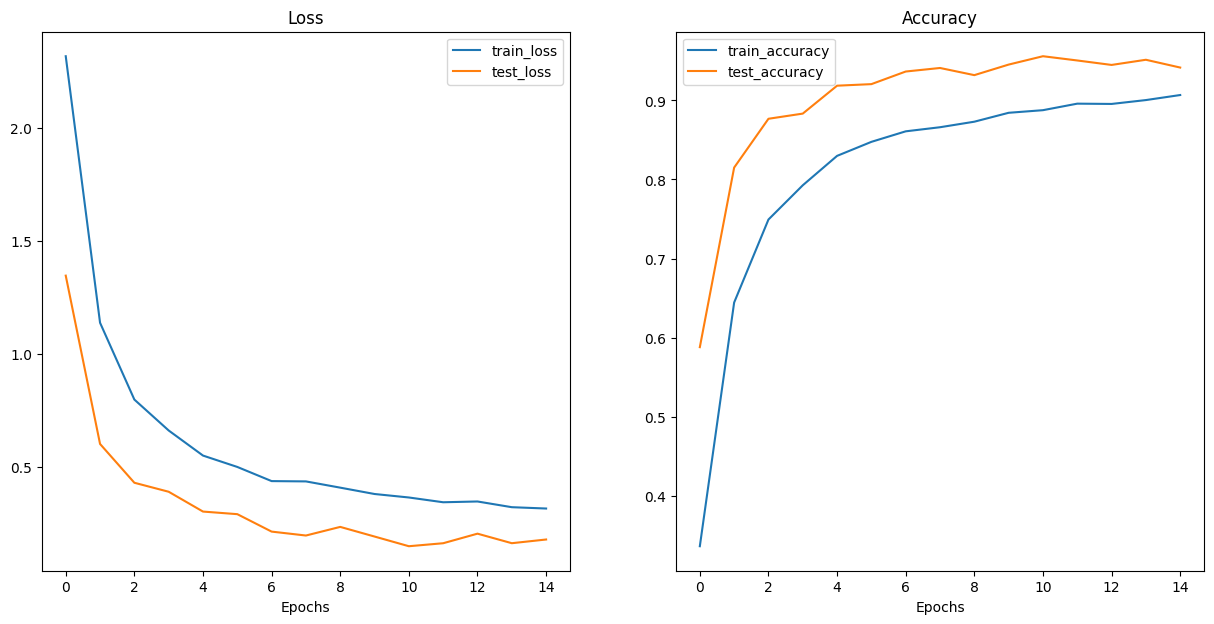

In [29]:
plot_loss_curves(results)

Save and Test the model

In [31]:
pickle_out= open("model_trained.p","wb")
pickle.dump(model,pickle_out)
pickle_out.close()
cv2.waitKey(0)

-1

In [25]:
frameWidth= 640         # CAMERA RESOLUTION
frameHeight = 480
brightness = 180
threshold = 0.9        # PROBABLITY THRESHOLD
font = cv2.FONT_HERSHEY_SIMPLEX

In [26]:
cap = cv2.VideoCapture(0)
cap.set(3, frameWidth)
cap.set(4, frameHeight)
cap.set(10, brightness)
# IMPORT THE TRANNIED MODEL
pickle_in=open("model_trained.p","rb") 
model=pickle.load(pickle_in)

In [27]:
def getCalssName(classNo):
  if   classNo == 0: return 'Speed Limit 20 km/h'
  elif classNo == 1: return 'Speed Limit 30 km/h'
  elif classNo == 2: return 'Speed Limit 50 km/h'
  elif classNo == 3: return 'Speed Limit 60 km/h'
  elif classNo == 4: return 'Speed Limit 70 km/h'
  elif classNo == 5: return 'Speed Limit 80 km/h'
  elif classNo == 6: return 'End of Speed Limit 80 km/h'
  elif classNo == 7: return 'Speed Limit 100 km/h'
  elif classNo == 8: return 'Speed Limit 120 km/h'
  elif classNo == 9: return 'No passing'
  elif classNo == 10: return 'No passing for vechiles over 3.5 metric tons'
  elif classNo == 11: return 'Right-of-way at the next intersection'
  elif classNo == 12: return 'Priority road'
  elif classNo == 13: return 'Yield'
  elif classNo == 14: return 'Stop'
  elif classNo == 15: return 'No vechiles'
  elif classNo == 16: return 'Vechiles over 3.5 metric tons prohibited'
  elif classNo == 17: return 'No entry'
  elif classNo == 18: return 'General caution'
  elif classNo == 19: return 'Dangerous curve to the left'
  elif classNo == 20: return 'Dangerous curve to the right'
  elif classNo == 21: return 'Double curve'
  elif classNo == 22: return 'Bumpy road'
  elif classNo == 23: return 'Slippery road'
  elif classNo == 24: return 'Road narrows on the right'
  elif classNo == 25: return 'Road work'
  elif classNo == 26: return 'Traffic signals'
  elif classNo == 27: return 'Pedestrians'
  elif classNo == 28: return 'Children crossing'
  elif classNo == 29: return 'Bicycles crossing'
  elif classNo == 30: return 'Beware of ice/snow'
  elif classNo == 31: return 'Wild animals crossing'
  elif classNo == 32: return 'End of all speed and passing limits'
  elif classNo == 33: return 'Turn right ahead'
  elif classNo == 34: return 'Turn left ahead'
  elif classNo == 35: return 'Ahead only'
  elif classNo == 36: return 'Go straight or right'
  elif classNo == 37: return 'Go straight or left'
  elif classNo == 38: return 'Keep right'
  elif classNo == 39: return 'Keep left'
  elif classNo == 40: return 'Roundabout mandatory'
  elif classNo == 41: return 'End of no passing'
  elif classNo == 42: return 'End of no passing by vechiles over 3.5 metric tons'

In [28]:
while True:
  # READ IMAGE
  success, imgOrignal = cap.read()

  # Check if the frame was successfully captured
  if not success:
    print("Error: Could not read frame from camera.")
    break  # Exit the loop if frame capture fails

  # PROCESS IMAGE
  img = np.asarray(imgOrignal, dtype=np.uint8) # Ensure img is of dtype uint8
  img = cv2.resize(img, (32, 32))
  img = preprocessing(img)
  cv2.imshow("Processed Image", img)
  img = img.reshape(1, 1, 32, 32)
  cv2.putText(imgOrignal, "CLASS: " , (20, 35), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
  cv2.putText(imgOrignal, "PROBABILITY: ", (20, 75), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
  # PREDICT IMAGE
  img = torch.from_numpy(img).float().to(device)

  with torch.inference_mode():
    predictions = model(img)

  classIndex = torch.argmax(predictions, dim=1).item()  # Get the predicted class index

  probabilityValue = torch.max(torch.softmax(predictions, dim=1)).item()  # Get the maximum probability
  if probabilityValue > threshold:
    cv2.putText(imgOrignal,str(classIndex)+" "+str(getCalssName(classIndex)), (120, 35), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(imgOrignal, str(round(probabilityValue*100,2) )+"%", (180, 75), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.imshow("Result", imgOrignal)

  if cv2.waitKey(1) and 0xFF == ord('q'):
    cv2.destroyAllWindows()
    break

KeyboardInterrupt: 

: 